In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix)

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
# data
df_train = pd.read_csv("/Users/dana/Desktop/AHI/01_PAML/Project/ML_project_AHI_2025/Part_2/train_pca_data_imputed.csv")
df_val   = pd.read_csv("/Users/dana/Desktop/AHI/01_PAML/Project/ML_project_AHI_2025/Part_2/val_pca_data_imputed.csv")

In [3]:
df_eval = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)

X = df_eval.drop(columns=["er"])
y = df_eval["er"]

In [4]:
# majority class baseline
dummy = DummyClassifier(strategy="most_frequent")

# linear baseline
lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_SEED))])

# best model: random forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=RANDOM_SEED)

models = {
    "majority_baseline": dummy,
    "logistic_regression": lr,
    "random_forest": rf}

In [5]:
# cross-validation evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

results = []

for name, model in models.items():
    scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    results.append({
        "model": name,
        "accuracy_mean": scores["test_accuracy"].mean(),
        "f1_mean": scores["test_f1"].mean(),
        "roc_auc_mean": scores["test_roc_auc"].mean()
    })

results_df = pd.DataFrame(results)
print(results_df)

                 model  accuracy_mean   f1_mean  roc_auc_mean
0    majority_baseline       0.853714  0.921070      0.500000
1  logistic_regression       0.910531  0.945462      0.944898
2        random_forest       0.922939  0.956573      0.938861


In [ ]:
# Bootstrap confidence intervals for Random Forest
from sklearn.utils import resample

n_boot = 1000
boot_scores = []

for i in range(n_boot):
    X_bs, y_bs = resample(X, y, stratify=y, random_state=i)

    rf.fit(X_bs, y_bs)
    y_prob = rf.predict_proba(X)[:, 1]

    boot_scores.append(roc_auc_score(y, y_prob))

ci_lower = np.percentile(boot_scores, 2.5) # 95% confidence interval
ci_upper = np.percentile(boot_scores, 97.5) # 95% confidence interval

print(f"roc_auc 95% ci: [{ci_lower:.3f}, {ci_upper:.3f}]")


roc_auc 95% ci: [0.966, 0.999]


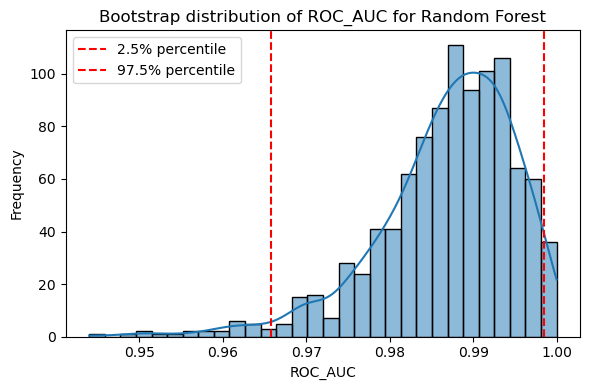

In [ ]:
# bootstrap distribution of roc_auc
plt.figure(figsize=(6, 4))
sns.histplot(boot_scores, bins=30, kde=True)
plt.axvline(ci_lower, color="red", linestyle="--", label="2.5% percentile")
plt.axvline(ci_upper, color="red", linestyle="--", label="97.5% percentile")
plt.xlabel("ROC_AUC")
plt.ylabel("Frequency")
plt.title("Bootstrap distribution of ROC_AUC for Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig("Bootstrap_distribution_ROC_AUC.png", dpi=300)
plt.show()

In [17]:
print(f"bootstrap mean roc_auc: {np.mean(boot_scores):.3f}")
print(f"bootstrap std roc_auc: {np.std(boot_scores):.3f}")

bootstrap mean roc_auc: 0.987
bootstrap std roc_auc: 0.008


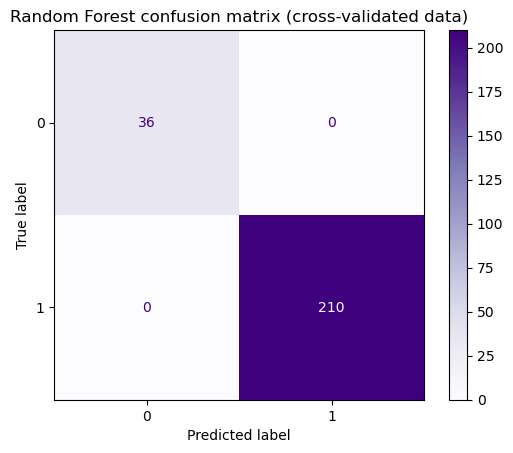

In [18]:
# Confusion matrix (cross-validated fit)
rf.fit(X, y)
y_pred = rf.predict(X)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(cmap="Purples")
plt.title("Random Forest confusion matrix (cross-validated data)")
plt.savefig("ConfusionMatrix_RF_cv_data.png", dpi=300)
plt.show()

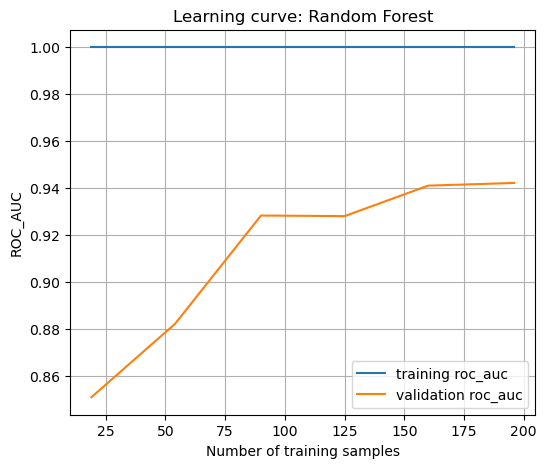

In [20]:
# Learning curve (data sufficiency)
train_sizes, train_scores, val_scores = learning_curve(
    rf,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 6),
    random_state=RANDOM_SEED)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6, 5))
plt.plot(train_sizes, train_mean, label="training roc_auc")
plt.plot(train_sizes, val_mean, label="validation roc_auc")
plt.xlabel("Number of training samples")
plt.ylabel("ROC_AUC")
plt.title("Learning curve: Random Forest")
plt.legend()
plt.grid(True)
plt.savefig("Learning_curve_RF.png", dpi=300)
plt.show()

In [14]:
for n, tr, va in zip(train_sizes, train_mean, val_mean):
    print(f"samples={n:4d} | train roc_auc={tr:.3f} | val roc_auc={va:.3f}")

samples=  19 | train roc_auc=1.000 | val roc_auc=0.851
samples=  54 | train roc_auc=1.000 | val roc_auc=0.882
samples=  90 | train roc_auc=1.000 | val roc_auc=0.928
samples= 125 | train roc_auc=1.000 | val roc_auc=0.928
samples= 160 | train roc_auc=1.000 | val roc_auc=0.941
samples= 196 | train roc_auc=1.000 | val roc_auc=0.942
